### Visualize the LVD Dwarfs in the SGA-2025

In [1]:
import os
import numpy as np
import fitsio
from astropy.table import Table
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
workdir = '/global/cfs/cdirs/desicollab/users/ioannis/SGA/2025'
photodir = '/pscratch/sd/i/ioannis/SGA2025/lvd'
regions = ['dr11-south', 'dr9-north']

In [3]:
@ticker.FuncFormatter
def major_formatter(x, pos):
    if (x >= 0.01) and (x < 0.1):
        return f'{x:.2f}'
    elif (x >= 0.1) and (x < 1):
        return f'{x:.1f}'
    else:
        return f'{x:.0f}'

In [4]:
def get_raslice(ra):
    if np.isscalar(ra):
        return f'{int(ra):03d}'
    else:
        return np.array([f'{int(onera):03d}' for onera in ra])

In [24]:
def read_photo(region):    
    photofile = os.path.join(workdir, 'parent', 'photo', f'parent-photo-{region}-lvd-v1.0.fits')
    print(photofile)
    photo = Table(fitsio.read(photofile))
    print(f'Read {len(photo)} galaxies from {photofile}')

    for band in ['G', 'R', 'I', 'Z']:
        photo[f'MAG_{band}'] = np.zeros(len(photo), 'f4')
        photo[f'MU_{band}'] = np.zeros(len(photo), 'f4')
    
        I = photo[f'FLUX_INIT_{band}'] > 0.
        if np.sum(I) > 0:
            diam = photo['DIAM_INIT'][I].value / 60. # [arcsec]
            photo[f'MAG_{band}'][I] = 22.5-2.5*np.log10(photo[f'FLUX_INIT_{band}'][I].value)
            photo[f'MU_{band}'][I] = photo[f'MAG_{band}'][I] + 2.5 * np.log10(np.pi * (diam/2. * 60.)**2.)
            
    return photo

photo = read_photo('dr11-south')
photo_n = read_photo('dr9-north')

/global/cfs/cdirs/desicollab/users/ioannis/SGA/2025/parent/photo/parent-photo-dr11-south-lvd-v1.0.fits
Read 446 galaxies from /global/cfs/cdirs/desicollab/users/ioannis/SGA/2025/parent/photo/parent-photo-dr11-south-lvd-v1.0.fits
/global/cfs/cdirs/desicollab/users/ioannis/SGA/2025/parent/photo/parent-photo-dr9-north-lvd-v1.0.fits
Read 183 galaxies from /global/cfs/cdirs/desicollab/users/ioannis/SGA/2025/parent/photo/parent-photo-dr9-north-lvd-v1.0.fits


In [26]:
np.intersect1d(photo['OBJNAME'].value, photo_n['OBJNAME'].value)

array(['BTS151', 'Bootes V', 'Canes Venatici I', 'DDO 133', 'HSC-10',
       'HSC-9', 'KK 165', 'KK 17', 'KK 69', 'KK 70', 'LV J1241+3251',
       'Leo A', 'NGC 2683', 'NGC 2683-dw1', 'NGC 4395', 'NGC 4627',
       'NGC 4631-dw1', 'NGC 4631-dw2', 'NGC 4631-dw3', 'NGC 784',
       'PGC 4560429', 'UGCA 292', 'dw1236+3336', 'dw1239+3230',
       'dw1239+3251'], dtype='<U30')

In [33]:
photo_n[photo_n['OBJNAME'] == 'A0952+69']['MU_G', 'MU_R', 'MU_Z', 'GINI_INIT_G', 'GINI_INIT_R', 'GINI_INIT_Z']

<Table length=1>
   MU_G      MU_R      MU_Z   GINI_INIT_G GINI_INIT_R GINI_INIT_Z
 float32   float32   float32    float32     float32     float32  
--------- --------- --------- ----------- ----------- -----------
27.547401 27.090122 26.262741   0.9201842   0.9659049   0.9709595

In [6]:
#I = (photo[f'FLUX_INIT_G'] == 0.) * (photo[f'FLUX_INIT_R'] == 0.) * (photo[f'FLUX_INIT_Z'] == 0.)  * (photo[f'FLUX_INIT_I'] == 0.) 
I = photo['OBJNAME'] == 'WLM'
photo[I]

<Table length=1>
         SGANAME          OBJNAME  STARFDIST  ...   MU_I    MAG_Z      MU_Z  
          str25            str30    float32   ... float32  float32   float32 
------------------------- ------- ----------- ... ------- --------- ---------
SGA2025 J000.4925-15.4608     WLM 0.092261575 ... 24.7123 10.729384 24.657574

In [7]:
0.4927283184100812, -15.461135667380356

(0.4927283184100812, -15.461135667380356)

In [8]:
def plot_style(font_scale=1.2, paper=False, talk=True):

    import seaborn as sns
    rc = {'font.family': 'serif'}#, 'text.usetex': True}
    #rc = {'font.family': 'serif', 'text.usetex': True,
    #       'text.latex.preamble': r'\boldmath'})
    palette, context = 'Set2', 'talk'

    if paper:
        context = 'paper'
        palette = 'deep'
        rc.update({'text.usetex': False})

    if talk:
        context = 'talk'
        palette = 'deep'
        #rc.update({'text.usetex': True})

    sns.set(context=context, style='ticks', font_scale=font_scale, rc=rc)
    sns.set_palette(palette, 12)

    colors = sns.color_palette()
    #sns.reset_orig()

    return sns, colors

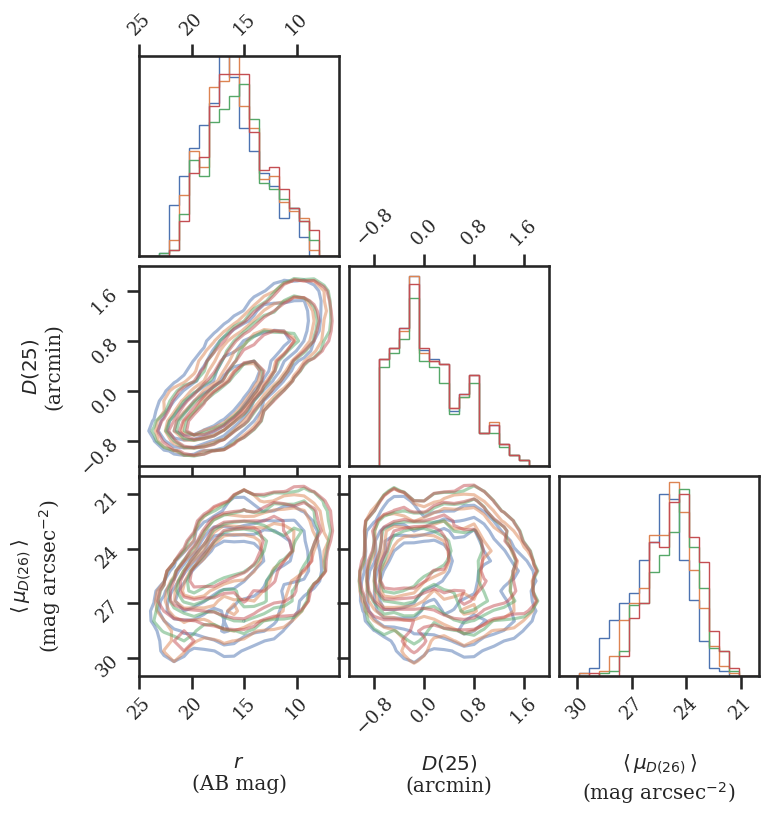

In [9]:
def lvd_properties(photo, png=None):
    import corner as cn
    from matplotlib.ticker import MaxNLocator, AutoLocator

    sns, colors = plot_style(talk=True, font_scale=0.8)
    diamlabels = [0.3, 1, 3, 10, 40]
    max_n_ticks = 4

    lims = [(25, 6), (-1.2, 2.), (31, 20)]
    labels = (r'$r$'+'\n(AB mag)', 
              r'$D(25)$'+'\n(arcmin)',
              r'$\langle\, \mu_{D(26)}\,\rangle$'+'\n(mag arcsec'+r'$^{-2}$)',
             )
    
    for iband, band in enumerate(['G', 'R', 'I', 'Z']):
        I = photo[f'FLUX_INIT_{band}'] > 0.
        if np.sum(I) == 0:
            #print(f'No {band.lower()}-band data for {",".join(photo["OBJNAME"][~I].value)}')
            continue
        
        diam = photo['DIAM_INIT'][I].value / 60. # [arcsec]
        logdiam = np.log10(diam)
        abmag = photo[f'MAG_{band}'][I].value
        mu = photo[f'MU_{band}'][I].value

        Xdata = np.array([abmag, logdiam, mu]).T

        if iband == 0:
            fig = cn.corner(Xdata, labels=labels, fill_contours=False, range=lims, 
                            labelpad=0.08, max_n_ticks=max_n_ticks, smooth=0.8,
                            top_ticks=True, plot_density=False, levels=[0.5, 0.75, 0.95, 0.995],
                            contour_kwargs={'colors': colors[iband], 'alpha': 0.5}, show_titles=False, quiet=True,
                            hist_kwargs={'lw': 1},
                            color=colors[iband])
        else:
            cn.corner(Xdata, labels=labels, fill_contours=False, range=lims, 
                      labelpad=0.08, max_n_ticks=max_n_ticks, smooth=0.8,
                      top_ticks=True, plot_density=False, levels=[0.5, 0.75, 0.95, 0.995],
                      contour_kwargs={'colors': colors[iband], 'alpha': 0.5}, show_titles=False, quiet=True,
                      hist_kwargs={'lw': 1},
                      color=colors[iband], fig=fig)
            
        if band == 0:
            for ii in range(len(labels)):
                ax = fig.axes[ii+ii*3]
                if ii != len(labels)-1:
                    ax.set_xticks([])
                xx = ax.twiny()
                xx.set_xlim(lims[ii])
                xx.set_xlabel(labels[ii])
                xx.xaxis.set_major_locator(MaxNLocator(max_n_ticks, prune='lower'))
                [l.set_rotation(45) for l in xx.get_xticklabels()]
                [l.set_rotation(45) for l in xx.get_xticklabels(minor=True)]
                if ii == 1:
                    xx.xaxis.set_major_formatter(major_formatter)
                    xx.set_xticks(np.log10(diamlabels))

            fig.axes[3].yaxis.set_major_formatter(major_formatter)
            fig.axes[3].set_yticks(np.log10(diamlabels))
            fig.axes[7].xaxis.set_major_formatter(major_formatter)
            fig.axes[7].set_xticks(np.log10(diamlabels))

            fig.subplots_adjust(wspace=0.05, hspace=0.05, bottom=0.15, top=0.9, right=0.95, left=0.12)

    if png:
        pngfile = os.path.join(figdir, png)
        print('Writing {}'.format(pngfile))
        fig.savefig(pngfile)#, bbox_inches='tight')
        plt.close(fig)

lvd_properties(photo)        

In [10]:
mus = np.array([photo['MU_G'].value, photo['MU_R'].value, photo['MU_I'].value, photo['MU_Z'].value]).T
#mus[mus == 0.] = -99.
maxmu = np.max(mus, axis=1)
maxmu

array([27.524778, 25.989887, 27.968515, 25.43613 , 25.256763, 26.793537,
       28.07185 , 28.085583, 25.485899, 27.91856 , 24.426205, 25.562958,
       25.126606, 26.74068 , 27.029736, 24.362387, 27.848885, 27.247406,
       24.394108, 27.858189, 24.408613, 24.659134, 24.300713, 24.743568,
       26.69463 , 23.860321, 28.451523, 25.17205 , 26.32258 , 25.174397,
       27.900265, 23.841537, 23.952099, 28.15939 , 25.716124, 23.166378,
       24.54    , 28.185394, 25.704731, 24.843836, 26.19077 , 27.72152 ,
       26.71539 , 27.470003, 24.65163 , 23.06672 , 25.950853, 27.973719,
       23.132318, 24.197748, 26.889542, 28.496025, 23.427128, 27.978909,
       24.895084, 28.93605 , 26.187664, 24.729362, 24.48441 , 23.73846 ,
       24.480309, 26.996962, 24.536224, 27.221329, 25.583517, 28.252884,
       25.59566 , 23.73553 , 22.930943, 25.530693, 25.331337, 22.748604,
       23.759966, 28.142117, 23.022963, 28.594307, 28.375977, 24.688286,
       26.437323, 23.835695, 24.859493, 24.44428 , 

In [11]:
I = np.argsort(photo['MU_R'])
#I = np.argsort(photo['RA'])
photo['OBJNAME', 'RA', 'DEC', 'DIAM_INIT', 'MAG_R', 'MU_R', 'MAG_Z', 'MU_Z'][I]

<Table length=446>
   OBJNAME            RA                DEC         ...   MAG_Z       MU_Z  
    str30          float64            float64       ...  float32    float32 
------------- ------------------ ------------------ ... ---------- ---------
     UGCA 319             195.56           -17.2375 ... 14.0357485 23.166082
  ESO 269-037 195.88829249999998         -46.586861 ...  14.621917 23.646305
 Andromeda XI           11.58208           33.80278 ...  16.792973  25.81736
  ESO 222-010  218.7624999999999 -49.42166666666667 ...  15.874931 22.720676
  ESO 269-058         197.637083          -46.99083 ...  11.310564 23.290274
     UGC 2905 59.250583333333324 16.522444444444442 ...        0.0       0.0
       Fluffy         199.545362         -44.157251 ...   17.50474 23.122921
Andromeda XII           11.86792           34.37722 ...  16.097431 27.507423
    GALFA Dw3         44.7343335         13.6299722 ...   17.09376 24.424053
      Bedin 1        287.6910417       -59.91729167 ...  15.181256 21.402308
          ...                ...                ... ...        ...       ...
      Segue 1           151.7504            16.0756 ...  13.946531 26.800503
   Scl-MM-Dw5           12.60776          -26.72726 ...   19.51263 27.137814
     Tucana V            354.347            -63.266 ...  14.622029 26.762665
  dw1120p1337            170.255             13.607 ...  15.414619 27.260365
   dw1323-40b              201.0           -40.8367 ...   19.41989 26.827745
  Leo Minor I            164.261             28.875 ...  16.556587 27.273256
   Scl-MM-Dw2           12.57108          -24.74961 ...  15.004467 27.697514
   Pisces VII             20.419             26.391 ...  19.169266 27.470238
        Leo V           172.7857             2.2194 ...  15.756962 27.449362
    dw1322-39           200.6558           -39.9084 ...   21.05786 28.880585

G 446 439
R 446 437
I 446 399
Z 446 437


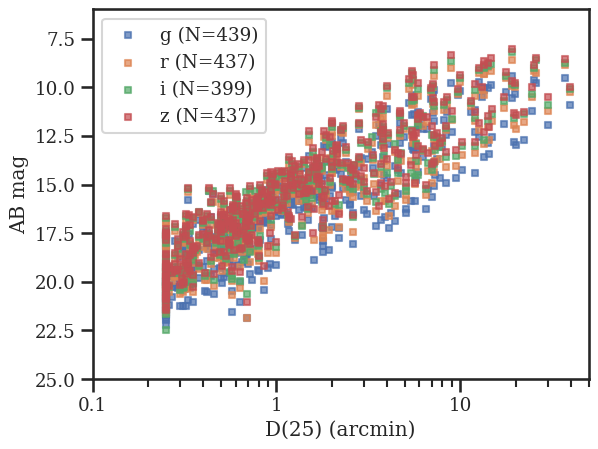

In [12]:
fig, ax = plt.subplots()
for band in ['G', 'R', 'I', 'Z']:
    I = photo[f'FLUX_INIT_{band}'] > 0.
    if np.sum(~I) > 0:
        #print(f'No {band.lower()}-band data for {",".join(photo["OBJNAME"][~I].value)}')
        pass

    print(band, len(photo), np.sum(I))
    diam = photo['DIAM_INIT'][I]/60.
    abmag = 22.5-2.5*np.log10(photo[f'FLUX_INIT_{band}'][I])
    ax.scatter(diam, abmag, s=20, label=f'{band.lower()} (N={np.sum(I)})',
               marker='s', alpha=0.7)
ax.legend(loc='upper left')
ax.set_xscale('log')
ax.xaxis.set_major_formatter(major_formatter)
ax.set_xlim(0.1, 50)
ax.set_ylim(25, 6)
ax.set_ylabel('AB mag')
ax.set_xlabel('D(25) (arcmin)');

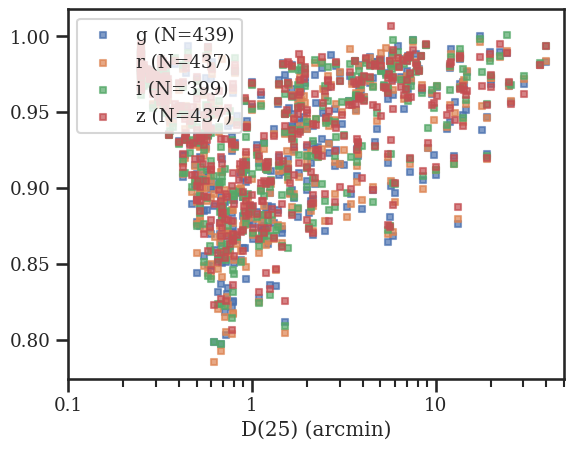

In [13]:
fig, ax = plt.subplots()
for band in ['G', 'R', 'I', 'Z']:
    I = photo[f'GINI_INIT_{band}'] > 0.
    gini = photo[f'GINI_INIT_{band}'][I]
    diam = photo['DIAM_INIT'][I]/60.
    ax.scatter(diam, gini, s=20, label=f'{band.lower()} (N={np.sum(I)})',
               marker='s', alpha=0.7)
ax.legend(loc='upper left')
ax.set_xscale('log')
ax.xaxis.set_major_formatter(major_formatter)
ax.set_xlim(0.1, 50)
#ax.set_ylim(25, 6)
#ax.set_ylabel('AB mag')
ax.set_xlabel('D(25) (arcmin)');

117
Hack!


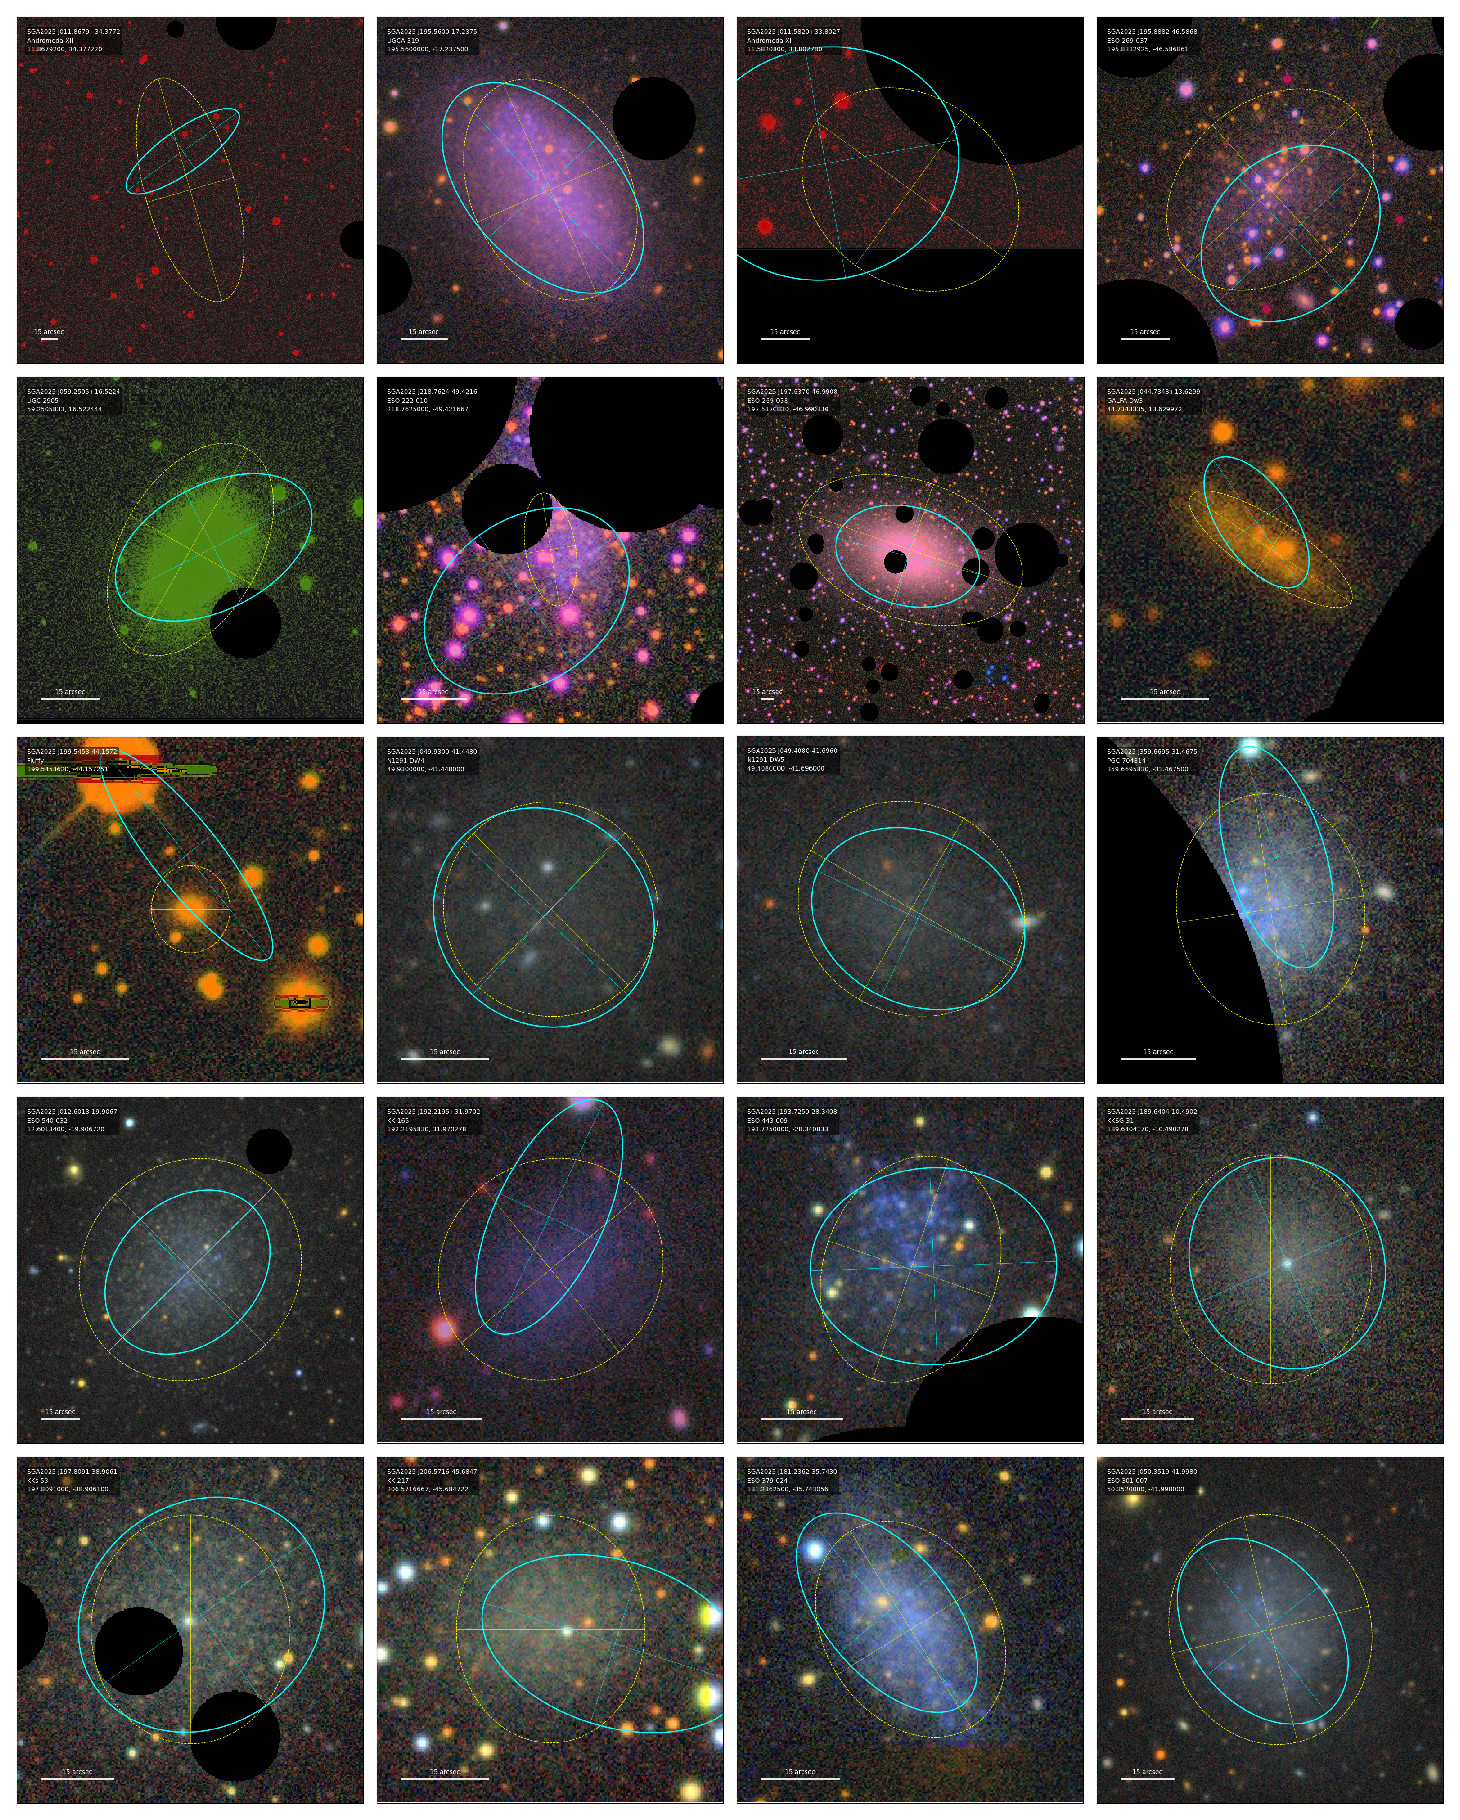

In [21]:
def annotated(allphoto, multipage=False, ncol=4, nrow=4, region='dr9-north'):
    from glob import glob
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle
    from matplotlib.backends.backend_pdf import PdfPages
    from matplotlib.image import imread

    qadir = os.path.join(workdir, 'parent', 'photo')
    pngdir = os.path.join(photodir, region, 'native')

    raslices = get_raslice(allphoto['RA'].value)
    objnames = [objname.replace('SGA2025 ', 'SGA2025_') for objname in allphoto['SGANAME'].value]

    suffix = '-lvd'
    ext = '-phot.png'
    prefix = 'native'
    inches_per_panel = 4.

    I, pngfiles = [], []
    for ii, (raslice, objname) in enumerate(zip(raslices, objnames)):
        pngfile = os.path.join(pngdir, raslice, f'{objname}{ext}')
        if os.path.isfile(pngfile):
            pngfiles.append(pngfile)
            I.append(ii)
        else:
            print(f'Skipping missing file {pngfile}')
    pngfiles = np.array(pngfiles)
    I = np.array(I)
    photo = allphoto[I]

    nobj = len(pngfiles)
    allindx = np.arange(nobj)
    
    if multipage:
        nperpage = ncol * nrow
        npage = int(np.ceil(nobj / nperpage))
        for ipage in [0]:#range(npage):
            print(f'Building page {ipage+1:,d}/{npage:,d}')
            indx = allindx[ipage*nperpage:(ipage+1)*nperpage]

            fig, ax = plt.subplots(nrow, ncol, figsize=(inches_per_panel*ncol, inches_per_panel*nrow))
            for iax, xx in enumerate(np.atleast_1d(ax).flat):
                if iax < len(indx):
                    img = imread(pngfiles[indx[iax]])
                    xx.imshow(img, interpolation='none')
                xx.axis('off')
            fig.subplots_adjust(wspace=0., hspace=0., bottom=0.05, top=0.95, left=0.05, right=0.95)
            plt.show()
            plt.close()
    else:
        print('Hack!')
        nobj = 20
        nrow = int(np.ceil(nobj / ncol))
        fig, ax = plt.subplots(nrow, ncol, figsize=(inches_per_panel*ncol, inches_per_panel*nrow))
        for iax, xx in enumerate(np.atleast_1d(ax).flat):
            if iax < nobj:
                img = imread(pngfiles[iax])
                xx.imshow(img, interpolation='None')
            xx.axis('off')
        fig.subplots_adjust(wspace=0., hspace=0., bottom=0.05, top=0.95, left=0.05, right=0.95)
        plt.show()
        plt.close()


I = photo['GINI_INIT_R'] < 0.9
setphoto = photo[I]
setphoto = setphoto[np.argsort(setphoto['GINI_INIT_R'])]
print(np.sum(I))
region = 'dr11-south'
annotated(setphoto, region=region)